In [1]:
import ee
ee.Authenticate()
# Initialize Earth Engine


True

In [2]:
ee.Initialize()

In [3]:


# Define the Bounding Box (BBOX) as [min_lon, min_lat, max_lon, max_lat]
#bbox = ee.Geometry.BBox(-113.5, 38.8, -113.0, 39.2)  # Example for Pahvant Valley

# xmin, ymin, xmax, ymax
box = [-110.75, 39.43, -110.7, 39.46]

bbox = ee.Geometry.BBox(*box)
# Load the Landsat 8 image collection
# Load Landsat 8 TOA collection
landsat = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA")
    .filterBounds(bbox)
    .filterDate("2023-06-01", "2023-06-30")
    .sort("CLOUD_COVER")
    .first()
)

# Select only the 30m bands to avoid projection issues
bands_30m = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']  # Excludes B8 (15m) & B10/B11 (100m)
landsat = landsat.select(bands_30m)

# Convert all bands to Float32 to ensure consistency
landsat = landsat.toFloat()

# Get the original projection and scale
orig_proj = landsat.select('B1').projection()
orig_scale = orig_proj.nominalScale()

# Reproject to preserve the Landsat grid
reprojected_image = landsat.reproject(crs=orig_proj, scale=orig_scale)



# Define export parameters
export_task = ee.batch.Export.image.toDrive(
    image=reprojected_image,
    description="Landsat_Grid_Preserved",
    folder="EarthEngineExports",
    fileNamePrefix="landsat_grid_sample",
    scale=30,  # Landsat native resolution
    region=bbox.bounds().getInfo()["coordinates"],  # Use bounding box
    fileFormat="GeoTIFF",
    crs=orig_proj.getInfo()["crs"]  # Use original Landsat CRS
)

# Start the export task
export_task.start()

print("Export started. Check Google Drive for the image.")


Export started. Check Google Drive for the image.


In [5]:
print(export_task.status())


{'state': 'COMPLETED', 'description': 'Landsat_Grid_Preserved', 'priority': 100, 'creation_timestamp_ms': 1738596547998, 'update_timestamp_ms': 1738596561320, 'start_timestamp_ms': 1738596550316, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1JT1SHkgIEBYqHcCk4AIZ_5ca6f9qgg-J'], 'attempt': 1, 'batch_eecu_usage_seconds': 0.09087080508470535, 'id': 'GO6NJYN7YK3O4ECUXUCJURBX', 'name': 'projects/114443260784/operations/GO6NJYN7YK3O4ECUXUCJURBX'}


In [8]:
# Select LANDSAT 8 image collection
landsat_collection = (ee.ImageCollection("LANDSAT/LC08/C02/T1")
    .filterBounds(bbox)
    .filterDate("2023-06-01", "2023-06-30")
    .sort("CLOUD_COVER")
)

# Extract image footprints as geometries
footprints = landsat_collection.map(lambda img: ee.Feature(img.geometry())).distinct(["system:index"])

# Convert to FeatureCollection
feature_collection = ee.FeatureCollection(footprints)

# Print result to check
print(feature_collection.getInfo())

# Export as a shapefile (optional)
export_task = ee.batch.Export.table.toDrive(
    collection=feature_collection,
    description="Landsat_Grid",
    fileFormat="SHP"
)
export_task.start()

print("Export started. Check Google Drive for the shapefile.")

{'type': 'FeatureCollection', 'columns': {}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-109.5143955049841, 39.552418098948955], [-109.51436626990703, 39.55379062796317], [-109.846535552764, 39.61877648630259], [-111.29941780606933, 39.89050242608544], [-111.67054996082894, 39.95666289043085], [-111.67287982227646, 39.956649346510815], [-111.67402819552294, 39.953929793427164], [-111.87958467188453, 39.26344777805886], [-112.17728321368358, 38.23893909011135], [-112.17655951735253, 38.23838256580303], [-112.16413511398679, 38.236063964171414], [-110.36382572938976, 37.895379038720016], [-110.08491131076289, 37.83984047828962], [-110.06986420912627, 37.83687436116259], [-110.06904678172765, 37.837509811280825], [-109.98194603453061, 38.10815008681375], [-109.93300415576743, 38.261419888475395], [-109.77621663831708, 38.748437766237906], [-109.72956964001902, 38.89240759324901], [-109.54516995695177, 39.458322089305966], [-109.5143955049841, 39.552

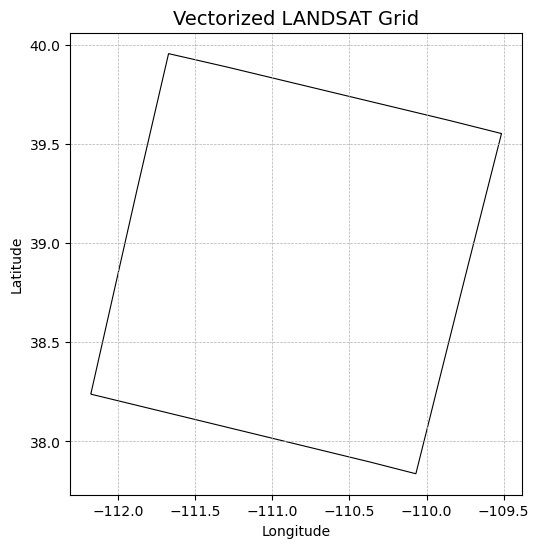

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.read_file("G:/My Drive/Landsat_Grid.shp")

# Plot the LANDSAT Grid
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=0.8)

# Customize the plot
ax.set_title("Vectorized LANDSAT Grid", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()


In [ ]:
-110.75, 39.43, -110.7, 39.46

In [35]:
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define the region of interest (modify as needed)
roi = ee.Geometry.BBox(-110.8, 39.4, -110.7, 39.5)  # Modify as needed

# Select a single Landsat 8 image
image = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA") \
    .filterBounds(roi) \
    .filterDate("2023-06-01", "2023-06-30") \
    .first()

# Select only the 30m bands to avoid projection issues
bands_30m = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']  # Excludes B8 (15m) & B10/B11 (100m)
image = image.select(bands_30m)

# Print result to check
print(image.getInfo())

# Get projection and pixel size
proj = image.select(0).projection()
pixel_size = proj.nominalScale()  # Landsat pixel size (~30m)

# Generate a pixel grid using `pixelCoordinates()`
pixel_grid = ee.Image.pixelCoordinates(proj)

# Sample pixels within the region
sampled_pixels = pixel_grid.sample(region=roi, scale=30)

# Filter out invalid features
valid_pixels = sampled_pixels.filter(ee.Filter.notNull(["longitude", "latitude"]))

# **Get pixel count safely**
print("Estimated pixel count:", valid_pixels.size().getInfo())

# Convert pixel centers to rectangular polygons
def create_pixel_polygon(feature):
    """Convert pixel center points to 30m x 30m bounding boxes"""
    lon = ee.Number(feature.get("longitude"))
    lat = ee.Number(feature.get("latitude"))
    half_size = pixel_size.divide(2)  # Half pixel size (15m for Landsat)

    bbox = ee.Geometry.Rectangle([
        lon.subtract(half_size), lat.subtract(half_size),
        lon.add(half_size), lat.add(half_size)
    ])

    return ee.Feature(bbox)

# Convert points to pixel-sized polygons
pixel_polygons = valid_pixels.map(create_pixel_polygon)

# Export the vectorized pixel grid as a Shapefile
export_task = ee.batch.Export.table.toDrive(
    collection=pixel_polygons,
    description="Landsat_Pixel_Grid",
    fileFormat="SHP"
)
export_task.start()

print("Export started. Check Google Drive for the shapefile.")


{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7721, 7841], 'crs': 'EPSG:32612', 'crs_transform': [30, 0, 434385, 0, -30, 4581915]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7721, 7841], 'crs': 'EPSG:32612', 'crs_transform': [30, 0, 434385, 0, -30, 4581915]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7721, 7841], 'crs': 'EPSG:32612', 'crs_transform': [30, 0, 434385, 0, -30, 4581915]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7721, 7841], 'crs': 'EPSG:32612', 'crs_transform': [30, 0, 434385, 0, -30, 4581915]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7721, 7841], 'crs': 'EPSG:32612', 'crs_transform': [30, 0, 434385, 0, -30, 4581915]}, {'id': 'B6', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [7721, 7841], 'crs': 'EPSG:

In [20]:
pixel_polygons

In [21]:
print(export_task.status())

{'state': 'FAILED', 'description': 'Landsat_Pixel_Grid', 'priority': 100, 'creation_timestamp_ms': 1738599113811, 'update_timestamp_ms': 1738599146710, 'start_timestamp_ms': 1738599118438, 'task_type': 'EXPORT_FEATURES', 'attempt': 1, 'batch_eecu_usage_seconds': 5.080406665, 'error_message': 'Error in map(ID=3):\nList.get: List is empty (index is 0).', 'id': 'OQPAETDY3OZPJ5XVSCJU55DP', 'name': 'projects/114443260784/operations/OQPAETDY3OZPJ5XVSCJU55DP'}


In [39]:
import ee
import geemap
import geopandas as gpd
from shapely.geometry import Polygon

# Initialize Google Earth Engine
ee.Initialize()

# Define the target latitude and longitude
latitude, longitude = 39.5, -112.5  # Replace with your target point

# Find the closest LANDSAT 8 scene
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA") \
    .filterBounds(ee.Geometry.Point([longitude, latitude])) \
    .sort("system:time_start") \
    .first()

# Get image metadata
image_geometry = landsat.geometry()
projection = landsat.select(0).projection()
scale = projection.nominalScale().getInfo()  # Pixel size in meters

# Get the bounding box coordinates
bounds = image_geometry.bounds().coordinates().getInfo()[0]
min_x, min_y = bounds[0]
max_x, max_y = bounds[2]

# Create a grid of polygons based on the Landsat scene extent and pixel size
rows = int((max_y - min_y) / scale)
cols = int((max_x - min_x) / scale)

polygons = []
for i in range(rows):
    for j in range(cols):
        x1 = min_x + j * scale
        x2 = x1 + scale
        y1 = min_y + i * scale
        y2 = y1 + scale
        polygons.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))

# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame({"geometry": polygons}, crs="EPSG:4326")

# Save to file or display
gdf.to_file("landsat_pixel_grid.geojson", driver="GeoJSON")

# Display the grid on a map
map_ = geemap.Map(center=(latitude, longitude), zoom=10)
map_.addLayer(landsat, {}, "Landsat Scene")
map_.add_gdf(gdf, layer_name="Pixel Grid")
#map_.show()
map_

Map(center=[39.5, -112.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [41]:
gdf

,geometry


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.read_file("G:/My Drive/Landsat_Grid.shp")

# Plot the LANDSAT Grid
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=0.8)

# Customize the plot
ax.set_title("Vectorized LANDSAT Grid", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()
